# Untargeted Metabolomics Pre-Processing

The universal workflow for untargeted metabolomics always consists of
feature detection in the individual MS sample files and their linkage to
consensus features with common m/z and retention time values. In
addition, there are optional steps such as adduct detection and
annotation of features with associated MS2 spectra.

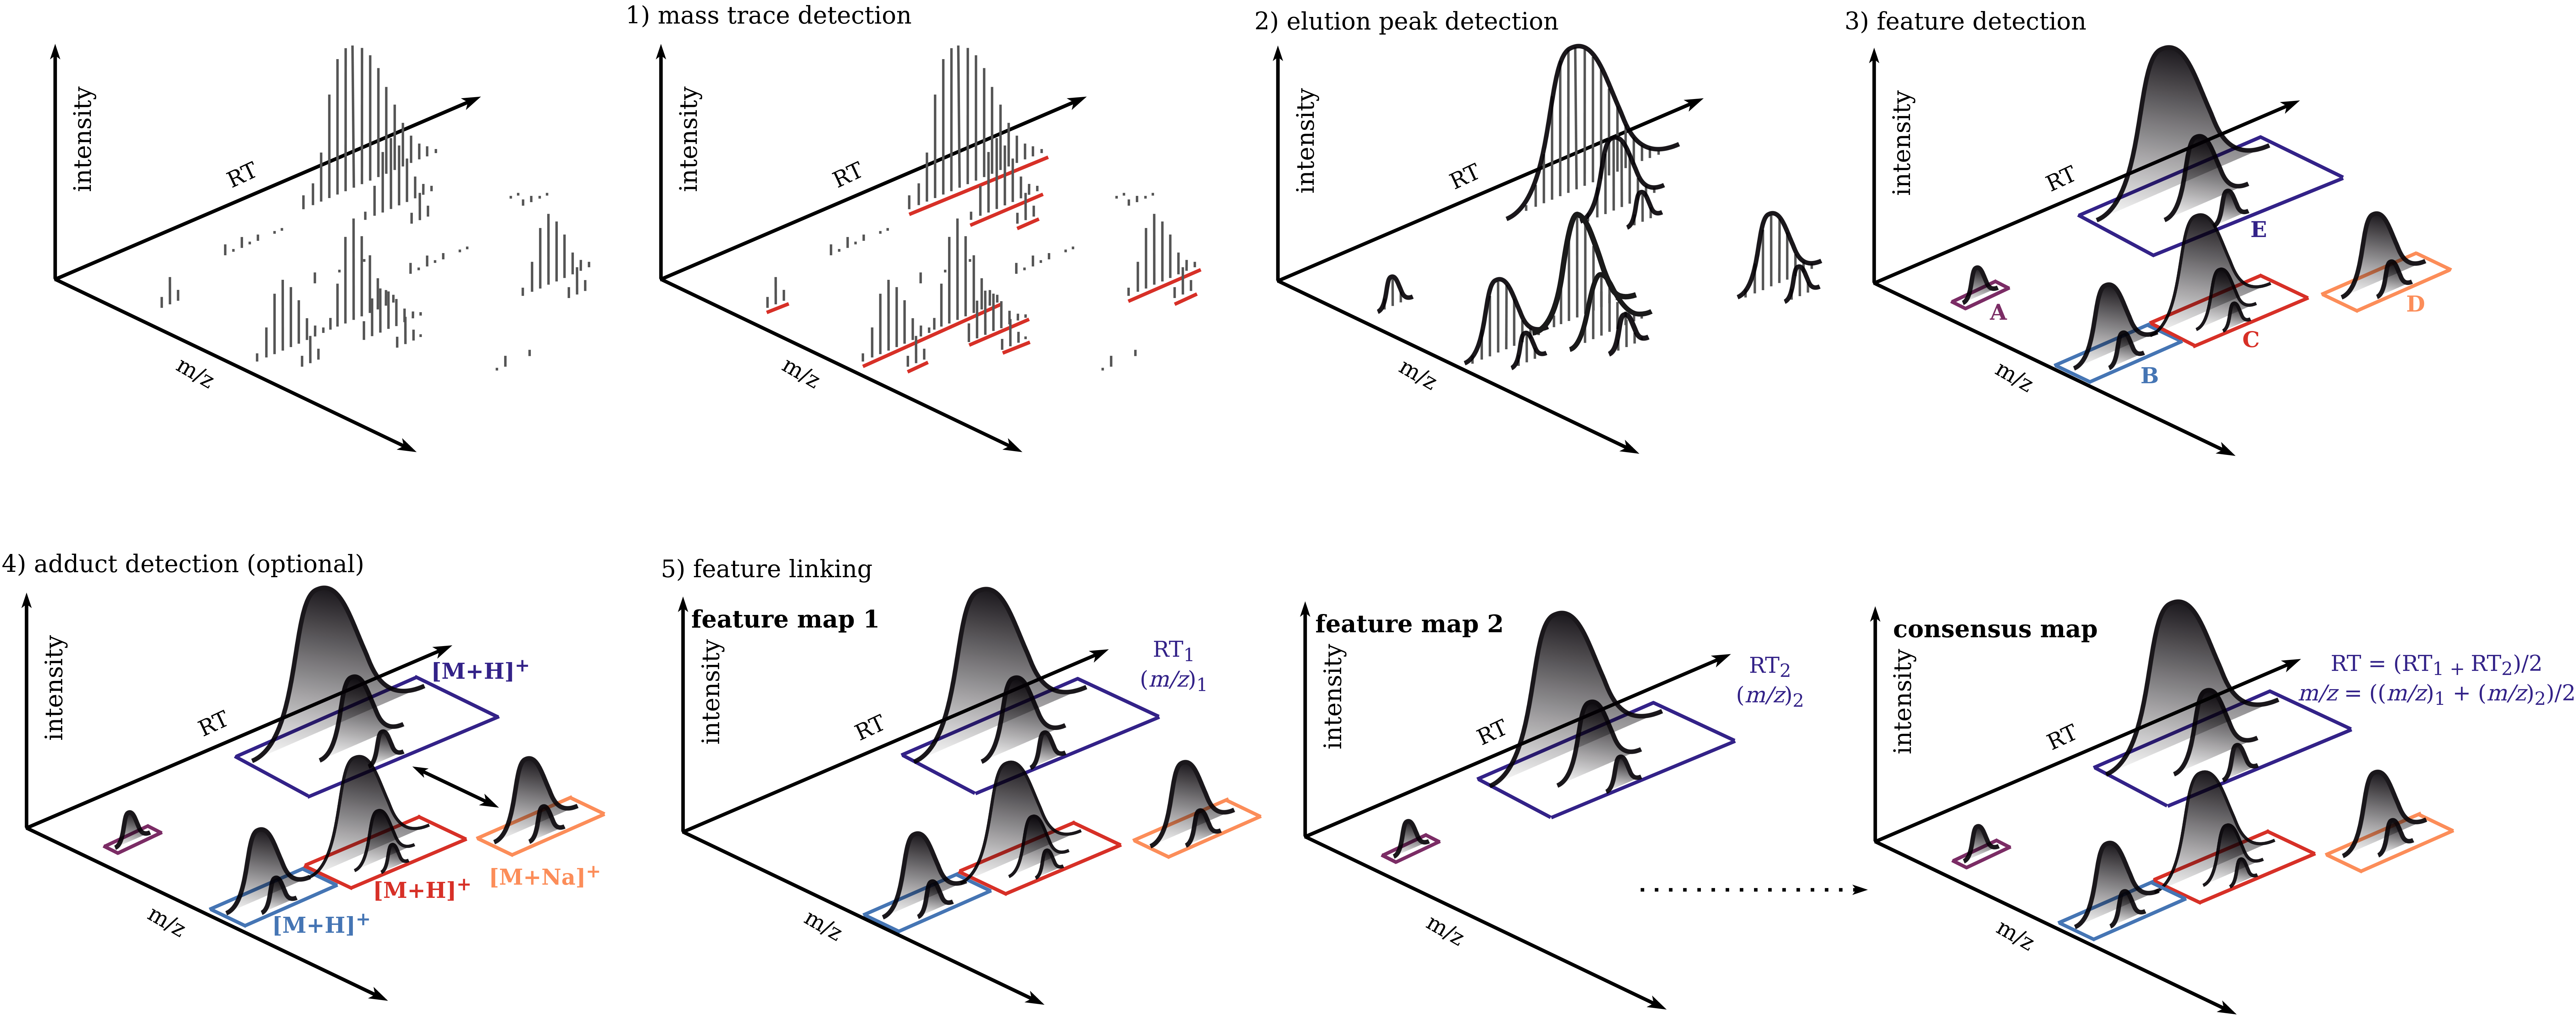

First, download two example `mzML` files.

In [ ]:
from urllib.request import urlretrieve
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master"
urlretrieve (gh + "/src/data/Metabolomics_1.mzML", "Metabolomics_1.mzML")
urlretrieve (gh + "/src/data/Metabolomics_2.mzML", "Metabolomics_2.mzML")

For each `mzML` file do mass trace, elution peak and feature detection.

In [ ]:
from pyopenms import *
import os

mzML_files = ["Metabolomics_1.mzML", "Metabolomics_2.mzML"]

feature_maps = []
for file in mzML_files:
    # load mzML file into MSExperiment
    exp = MSExperiment()    
    MzMLFile().load(file, exp) # load each mzML file to an OpenMS file format (MSExperiment)

    # mass trace detection
    mass_traces = [] # introduce an empty list where the mass traces will be loaded
    mtd = MassTraceDetection()
    mtd_par = mtd.getDefaults() # get the default parameters in order to edit them
    mtd_par.setValue("mass_error_ppm", 10.0) # high-res instrument, orbitraps
    mtd_par.setValue("noise_threshold_int", 1.0e04) # data-dependent (usually works for orbitraps)
    mtd.setParameters(mtd_par) # set the new parameters
    mtd.run(exp, mass_traces, 0) # run mass trace detection

    # elution peak detection
    mass_traces_deconvol = []
    epd = ElutionPeakDetection()
    epd_par = epd.getDefaults()
    epd_par.setValue("width_filtering", "fixed") # The fixed setting filters out mass traces outside the [min_fwhm: 1.0, max_fwhm: 60.0] interval
    epd.setParameters(epd_par)
    epd.detectPeaks(mass_traces, mass_traces_deconvol)

    # feature detection
    feature_map = FeatureMap() # output features 
    chrom_out = [] # output chromatograms 
    ffm = FeatureFindingMetabo()
    ffm_par = ffm.getDefaults() 
    ffm_par.setValue("remove_single_traces", "true") # remove mass traces without satellite isotopic traces
    ffm.setParameters(ffm_par)
    ffm.run(mass_traces_deconvol, feature_map, chrom_out)
    feature_map.setUniqueIds() # Assigns a new, valid unique id per feature
    feature_map.setPrimaryMSRunPath([file.encode()]) # Sets the file path to the primary MS run (usually the mzML file)
    feature_maps.append(feature_map)

Align feature retention times based on the feature map with the highest
number of features (reference map).

In [ ]:
# use as reference for alignment, the file with the largest number of features (works well if you have a pooled QC for example)
ref_index = feature_maps.index(sorted(feature_maps, key=lambda x: x.size())[-1])

aligner = MapAlignmentAlgorithmPoseClustering()

trafos = {}

# parameter optimization
aligner_par= aligner.getDefaults()
aligner_par.setValue("max_num_peaks_considered", -1) # infinite
aligner_par.setValue("pairfinder:distance_MZ:max_difference", 10.0) # Never pair features with larger m/z distance
aligner_par.setValue("pairfinder:distance_MZ:unit", "ppm")
aligner.setParameters(aligner_par)
aligner.setReference(feature_maps[ref_index])

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index+1:]:
    trafo = TransformationDescription() # save the transformed data points
    aligner.align(feature_map, trafo)
    trafos[feature_map.getMetaValue("spectra_data")[0].decode()] = trafo
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True)

Align `mzML` files aligment based on `FeatureMap` alignment (optional,
only for GNPS).

In [ ]:
# align mzML files based on FeatureMap alignment and store as mzML files (for GNPS!)
for file in mzML_files:
    exp = MSExperiment()
    MzMLFile().load(file, exp)
    exp.sortSpectra(True)
    exp.setMetaValue("mzML_path", file)
    if file not in trafos.keys():
        MzMLFile().store(file[:-5]+"_aligned.mzML", exp)
        continue
    transformer = MapAlignmentTransformer()
    trafo_description = trafos[file]
    transformer.transformRetentionTimes(exp, trafo_description, True)
    MzMLFile().store(file[:-5]+"_aligned.mzML", exp)
mzML_files = [file[:-5]+"_aligned.mzML" for file in mzML_files]

Map MS2 spectra to features as `PeptideIdentification` objects
(optional, only for GNPS).

In [ ]:
feature_maps_mapped = []
use_centroid_rt = False
use_centroid_mz = True
mapper = IDMapper()
for file in mzML_files:
    exp = MSExperiment()
    MzMLFile().load(file, exp)
    for i, feature_map in enumerate(feature_maps):
        if feature_map.getMetaValue("spectra_data")[0].decode() == exp.getMetaValue("mzML_path"):
            peptide_ids = []
            protein_ids = []
            mapper.annotate(feature_map, peptide_ids, protein_ids, use_centroid_rt, use_centroid_mz, exp)
            fm_new = FeatureMap(feature_map)
            fm_new.clear(False)
            # set unique identifiers to protein and peptide identifications
            prot_ids = []
            if len(feature_map.getProteinIdentifications()) > 0:
                prot_id = feature_map.getProteinIdentifications()[0]
                prot_id.setIdentifier(f"Identifier_{i}")
                prot_ids.append(prot_id)
            fm_new.setProteinIdentifications(prot_ids)
            for feature in feature_map:
                pep_ids = []
                for pep_id in feature.getPeptideIdentifications():
                    pep_id.setIdentifier(f"Identifier_{i}")
                    pep_ids.append(pep_id)
                feature.setPeptideIdentifications(pep_ids)
                fm_new.push_back(feature)
            feature_maps_mapped.append(fm_new)
feature_maps = feature_maps_mapped

Detect adducts (optional, only for SIRIUS and GNPS Ion Identity
Molecular Networking).

In [ ]:
feature_maps_adducts = []
for feature_map in feature_maps:
    mfd = MetaboliteFeatureDeconvolution()
    mdf_par = mfd.getDefaults()
    mdf_par.setValue("potential_adducts", [b"H:+:0.4",b"Na:+:0.2",b"NH4:+:0.2", b"H-1O-1:+:0.1", b"H-3O-2:+:0.1"])
    mfd.setParameters(mdf_par)
    feature_map_adduct = FeatureMap()
    mfd.compute(feature_map, feature_map_adduct,
                ConsensusMap(), ConsensusMap())
    feature_maps_adducts.append(feature_map_adduct)
feature_maps = feature_maps_adducts

# for SIRIUS store the feature maps as featureXML files!
for feature_map in feature_maps:
    FeatureXMLFile().store(feature_map.getMetaValue("spectra_data")[0].decode()[:-4]+"featureXML", feature_map)

Link features in a `ConsensusMap`.

In [ ]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(
        feature_map.getMetaValue("spectra_data")[0].decode())
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)
consensus_map.setUniqueIds()
ConsensusXMLFile().store("FeatureMatrix.consensusXML", consensus_map)

To get a final feature matrix in a table format, export the consensus
features in a `pandas DataFrame`.

In [ ]:
df = consensus_map.get_df()